# Top-down vs. bottom-up

Suppose we want to compute $3 \times 7 + 2 \times 9$.

*Operator precedence*&mdash;also called &ldquo;order of operations&rdquo;&mdash;is a matter of accepted notational convention. (We could agree on a different convention, in which case we&rsquo;d have to put parentheses in different places to express the same things.) It determines the meaning of an expression. In this example, the expression is a sum of products.

But operator precedence does not always determine *evaluation order*. In this example, we can do the multiplications in either order, but they both must be computed before the addition, because their results are what get added.

This expression tree shows the relationship between the **subproblems**:

In [1]:
from graphviz import Digraph

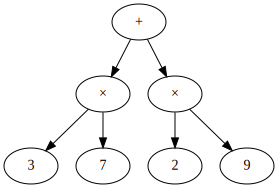

In [2]:
# Draw the tree.
tree = Digraph()
tree.node('left-times', label='\N{MULTIPLICATION SIGN}')
tree.node('right-times', label='\N{MULTIPLICATION SIGN}')
tree.edge('+', 'left-times')
tree.edge('left-times', '3')
tree.edge('left-times', '7')
tree.edge('+', 'right-times')
tree.edge('right-times', '2')
tree.edge('right-times', '9')
tree

*We can evaluate this expression **top-down***, which is naturally recursive. When we try to compute the sum, we notice that the product $3 \times 7$ must first be computed, so do that. For this, we must first know the values of $3$ and $7$, but they&rsquo;re literals, so we already do. Having now *returned* to our effort to compute the sum, we notice that the product $2 \times 9$ must first be computed, so do that. For this, we must know the values of $2$ and $9$, but they&rsquo;re literals, so we do. (Or we could have gone right to left and computed $2 \times 9$ before $3 \times 7$.) Then the sum can be computed.

*Or we can evaluate it **bottom-up***, which is naturally iterative. Notice that the solutions to all subproblems of $3 \times 7$&mdash;the literals $3$ and $7$&mdash;are known, so compute $3 \times 7$. Notice that the solutions to all subproblems of $2 \times 9$&mdash;the literals $2$ and $9$&mdash;are known, so compute $2 \times 9$. (Or we could have gone right to left and computed $2 \times 9$ before $3 \times 7$.) Notice, now, that the solutions to all subproblems of the whole sum are known, so compute it.

Mergesort likewise consists of smaller subproblems whose solutions are needed by bigger subproblems.  You&rsquo;ve implemented **top-down mergesort**, in `recursion.merge_sort`.

Can you implement **bottom-up mergesort**?

---

**Note:** Mergesort doesn&rsquo;t have *overlapping* subproblems, but many other important problems do, and the subject of overlapping subproblems is examined and visualized below.

## General example of a simple case of overlapping subproblems

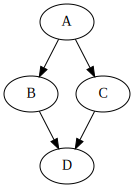

In [3]:
dag = Digraph()
dag.edge('A', 'B')
dag.edge('A', 'C')
dag.edge('B', 'D')
dag.edge('C', 'D')
dag

## Fibonacci

In [4]:
from fibonacci import fibonacci

In [5]:
fibonacci(10)

55

In [6]:
def drawfibn(n):
    fib = Digraph()
    for x in range(n + 1):
        if x == 0:
            fib.node('0')
        elif x ==1:
            fib.node('1')
        else: 
            fib.edge(str(x),str(x-2))
            fib.edge(str(x),str(x-1))
    return fib

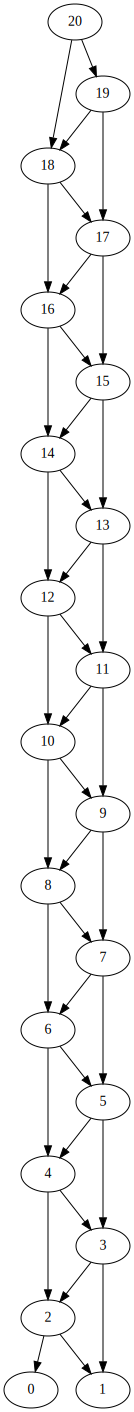

In [7]:
drawfibn(20)

**Note:** The function `fibonacci_better` has been moved to `fibonacci.py`.

## Mergesort - Unbalanced merges

*Examining when and how often unequal-length lists are merged.*

Since the two-way merger is supplied by dependency injection, we can easily supply an instrumented two-way merger that reports information about its arguments or return value, some or all of the time.

In particular, if we are interested in when the branches (sides) being merged differ in length, we can make a merger that delegates to some existing two-way merge implementation to do the actual merging, but also, when the lengths of its arguments are different, reports their lengths by printing them (or we could log them).

Do that. Implement a function, `verbose_merge`, below this cell, that can be passed as the `merge=` keyword-only argument of the merge sort implementations in `recursion.py`. Then try it with various values on all those implementations.

Some example code to use it already appears below. Feel free to add more!

In [8]:
import recursion

In [9]:
def _report_length(items):
    length = len(items)
    return f'{length} element' if length == 1 else f'{length} elements'

def verbose_merge(left, right):
    if len(left) != len(right):
        left_report = _report_length(left)
        right_report = _report_length(right)
        print(f'Merging {left_report} with {right_report}.')
        
    return recursion.merge_two(left, right)

In [10]:
# Should output:  Merging 1 element with 2 elements.
recursion.merge_sort([30, 20, 10], merge=verbose_merge)

Merging 1 element with 2 elements.


[10, 20, 30]

In [11]:
recursion.merge_sort_bottom_up_unstable([30, 20, 10], merge=verbose_merge)

Merging 1 element with 2 elements.


[10, 20, 30]

In [12]:
recursion.merge_sort_bottom_up([30, 20, 10], merge=verbose_merge)

Merging 2 elements with 1 element.


[10, 20, 30]

In [13]:
recursion.merge_sort([7, 6, 5, 4, 3, 2, 1], merge=verbose_merge)

Merging 1 element with 2 elements.
Merging 3 elements with 4 elements.


[1, 2, 3, 4, 5, 6, 7]

In [14]:
recursion.merge_sort_bottom_up_unstable([7, 6, 5, 4, 3, 2, 1], merge=verbose_merge)

Merging 1 element with 2 elements.
Merging 3 elements with 4 elements.


[1, 2, 3, 4, 5, 6, 7]

In [15]:
recursion.merge_sort_bottom_up([7, 6, 5, 4, 3, 2, 1], merge=verbose_merge)

Merging 2 elements with 1 element.
Merging 4 elements with 3 elements.


[1, 2, 3, 4, 5, 6, 7]

In [16]:
# This will report *many* mismatches in length. (Try it.) Does that affect the
# asymptotic time complexity? Is it otherwise a performance problem?
#result = recursion.merge_sort(range(5000), merge=verbose_merge)0

In [17]:
result = recursion.merge_sort_bottom_up_unstable(range(5000), merge=verbose_merge)

Merging 8 elements with 16 elements.
Merging 16 elements with 24 elements.
Merging 32 elements with 40 elements.
Merging 64 elements with 72 elements.
Merging 136 elements with 256 elements.
Merging 392 elements with 512 elements.
Merging 904 elements with 1024 elements.
Merging 1024 elements with 1928 elements.
Merging 2048 elements with 2952 elements.


In [18]:
result = recursion.merge_sort_bottom_up(range(5000), merge=verbose_merge)

Merging 128 elements with 8 elements.
Merging 256 elements with 136 elements.
Merging 512 elements with 392 elements.
Merging 4096 elements with 904 elements.


Did a situation arise where some mismatches were clearly not a performance problem? Write another function similar to `verbose_merge` that avoids reporting the least important mismatches. If the omissions may, in practice, sometimes cause a performance problem to go unnoticed, then include comments to document how that could happen.

In [19]:
def discerning_merge(left, right):
    if abs(len(left) - len(right)) > 1:
        left_report = _report_length(left)
        right_report = _report_length(right)
        print(f'Merging {left_report} with {right_report}.')
        
    return recursion.merge_two(left, right)

In [20]:
result = recursion.merge_sort(range(5000), merge=discerning_merge)

In [21]:
result = recursion.merge_sort_bottom_up_unstable(range(5000), merge=discerning_merge)

Merging 8 elements with 16 elements.
Merging 16 elements with 24 elements.
Merging 32 elements with 40 elements.
Merging 64 elements with 72 elements.
Merging 136 elements with 256 elements.
Merging 392 elements with 512 elements.
Merging 904 elements with 1024 elements.
Merging 1024 elements with 1928 elements.
Merging 2048 elements with 2952 elements.


In [22]:
result = recursion.merge_sort_bottom_up(range(5000), merge=discerning_merge)

Merging 128 elements with 8 elements.
Merging 256 elements with 136 elements.
Merging 512 elements with 392 elements.
Merging 4096 elements with 904 elements.


In [23]:
result = recursion.merge_sort(range(100_000), merge=discerning_merge)

In [24]:
result = recursion.merge_sort_bottom_up_unstable(range(100_000), merge=discerning_merge)

Merging 32 elements with 64 elements.
Merging 64 elements with 96 elements.
Merging 160 elements with 256 elements.
Merging 256 elements with 416 elements.
Merging 672 elements with 1024 elements.
Merging 1696 elements with 2048 elements.
Merging 2048 elements with 3744 elements.
Merging 4096 elements with 5792 elements.
Merging 8192 elements with 9888 elements.
Merging 16384 elements with 18080 elements.
Merging 34464 elements with 65536 elements.


In [25]:
result = recursion.merge_sort_bottom_up(range(100_000), merge=discerning_merge)

Merging 128 elements with 32 elements.
Merging 512 elements with 160 elements.
Merging 1024 elements with 672 elements.
Merging 32768 elements with 1696 elements.
Merging 65536 elements with 34464 elements.


In [26]:
result = recursion.merge_sort(range(1_000_000), merge=discerning_merge)

In [27]:
result = recursion.merge_sort_bottom_up_unstable(range(1_000_000), merge=discerning_merge)

Merging 64 elements with 128 elements.
Merging 128 elements with 192 elements.
Merging 256 elements with 320 elements.
Merging 576 elements with 1024 elements.
Merging 1024 elements with 1600 elements.
Merging 2048 elements with 2624 elements.
Merging 4096 elements with 4672 elements.
Merging 8192 elements with 8768 elements.
Merging 16960 elements with 32768 elements.
Merging 32768 elements with 49728 elements.
Merging 82496 elements with 131072 elements.
Merging 213568 elements with 262144 elements.
Merging 475712 elements with 524288 elements.


In [28]:
result = recursion.merge_sort_bottom_up(range(1_000_000), merge=discerning_merge)

Merging 512 elements with 64 elements.
Merging 16384 elements with 576 elements.
Merging 65536 elements with 16960 elements.
Merging 131072 elements with 82496 elements.
Merging 262144 elements with 213568 elements.
Merging 524288 elements with 475712 elements.


## Mergesort - Drawing subproblem trees

### Trying to use the existing dependency injection

Dependency injection is very powerful, and except for trivial inputs, every node in the tree of subproblems corresponds to at least one of:

- an argument to a two-way merge &ndash; if it is not the root
- a return value of a two-way merge &ndash; if it is not a leaf

(In trivial inputs, every node is both a root and a leaf, because there are zero or one nodes. Otherwise, no node is both a root and a leaf.)

So it is temping to try visualizing the tree of subproblems in an *arbitrary* mergesort routine (that takes a two-way merge function), by giving a two-way merge function that both merges add adds vertices and edges to a drawing:

In [29]:
def draw_mergesort_subproblems_attempt_1(values, *,
                                         sort=recursion.merge_sort,
                                         merge=recursion.merge_two):
    """
    Draw a graph of mergesort subproblems. Create nodes leaf-to-root.
    
    Leaves show base cases. Internal nodes show return values from merges.
    """
    vertices = {}  # Prevents vertices (which are lists) from being collected.
    graph = Digraph()
    
    def register_vertex(node_object):
        """Add a vertex if not already added. Return the vertex name."""
        if id(node_object) not in vertices:
            vertices[id(node_object)] = node_object
            graph.node(str(id(node_object)), label=repr(node_object))
        return str(id(node_object))
    
    def instrumented_merge(left, right):
        print(f'Merging {left!r} with {right!r}.')  # For debugging.
        parent = merge(left, right)
        left_name = register_vertex(left)
        right_name = register_vertex(right)
        parent_name = register_vertex(parent)
        graph.edge(parent_name, left_name)
        graph.edge(parent_name, right_name)
        return parent
    
    sort(values, merge=instrumented_merge)
    return graph

Although interesting, that does not quite do what we would like.

Merging ['B'] with ['C'].
Merging ['A'] with ['B', 'C'].


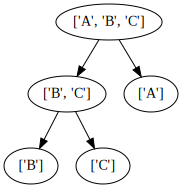

In [30]:
draw_mergesort_subproblems_attempt_1(['A', 'B', 'C'])

There are two things that go wrong:

1. Since we want to see the relationship between the subproblems, and it's more important for that to be clear than for us to see solutions, it would be better to show values before and after they are *split* (reading down the tree), rather than before and after they are *merged* (reading up the tree).

2. The order is not quite right. When $A$ is merged with $BC$, $A$ is on the left and $BC$ is on the right, but they are drawn in the other order. **Why?**

<details>
<summary><strong><em>Spoiler!</em> Click to expand/collapse why the tree is drawn out of order.</strong></summary>
The ordering problem in the drawn graph, shown above, is that $ABC$ is made by merging $A$ with $BC$, and $BC$ is formed by merging $B$ with $C$, but leaves are not created until they participate in a merge, so $B$ and $C$ are created to form $BC$, and it is only after $B$ and $C$ are created that $A$ is created to form $ABC$. This is even though $A$ is on the left when it merges with $BC$ to produce $ABC$. Since $B$ and $C$ are created before $A$, Graphviz draws $BC$, which has $B$ and $C$ as its children, to the left of $A$. But we want $A$ to be drawn to the left of $BC$.
</details>

So it is best to implement the drawing function in another way.

### Using "observed" versions of the merge sort implementations

Write a `merge_sort_observed` function in `recursion.py` that works like `merge_sort` but takes required keyword-only `node_observer` and `edge_observer` arguments. Put it immediately after the `merge_sort` function. Like `merge_sort`, it will have a recursive helper function that actually does the mergesorting.

1. Each call to the helper function will immediately call `node_observer` with its argument that corresponds to `values` in `merge_sort`. You may want to call this argument `node`.

2. When the helper function splits a list $AB$ (of any length) into $A$ and $B$, it will call `edge_observer` twice, one for the edge from $AB$ to $A$, and one for the edge from $AB$ to $B$, in that order.

3. For each subproblem (node/vertex), call `node_observer` exactly once.

4. For each subproblem relationship (edge), call `edge_observer` exactly once, *after `node_observer` has already been called for both endpoints.*

**To satisfy 3 and 4 above, it can be very useful to have the helper function accept more than one argument.** Think about how that may help. If you take that approach, what should the other argument be? Is there a case where that other argument has to be treated specially? (That is not the only possible implementation approach, but it does make things quite a bit easier!)

After implementing `recursion.merge_sort_observed`, write a function below this cell called `draw_mergesort_subproblems` that uses `merge_sort_observed`&mdash;or any other function that notifies observers in the same way, if passed as an optional keyword-only argument. (See the signature below.) Try it on various inputs. Some calls to it are already written below.

**Note:** Remembering that nodes are always observed before edges that connect them can help write simpler logic than was possible in the first attempt shown above. **The code below should be shorter than in "attempt 1."**

In [31]:
def draw_mergesort_subproblems(values, *,
                               sort=recursion.merge_sort_observed,
                               merge=recursion.merge_two):
    """
    Draw a graph of mergesort subproblems. Create nodes root to leaf.
    
    A parent node is a list before splitting. Its left and right children are
    the left and right sides produced by the split, respectively.
    
    Leaves are base cases. The root is the original top-level input list.
    """
    vertices = {}  # Keeps vertices (which are lists) from being collected.
    graph = Digraph()
    
    def observe_node(values):
        vertices[id(values)] = values  # Keep the vertex from being collected.
        graph.node(str(id(values)), label=repr(values))
    
    def observe_edge(parent, child):
        graph.edge(str(id(parent)), str(id(child)))
    
    sort(values, merge=merge,
         node_observer=observe_node, edge_observer=observe_edge)
    
    return graph

### `draw_mergesort_subproblems` with `merge_sort_observed`

Calling `draw_mergesort_subproblems` on `['A', 'B', 'C']` without specifying a `sort` should use `merge_sort_observed` and should show the same drawing as:

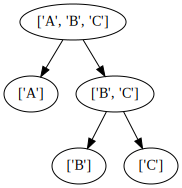

In [32]:
g = Digraph()
g.edge("['A', 'B', 'C']", "['A']")
g.edge("['A', 'B', 'C']", "['B', 'C']")
g.edge("['B', 'C']", "['B']")
g.edge("['B', 'C']", "['C']")
g

That is, the above drawing should look the same as the drawing below:

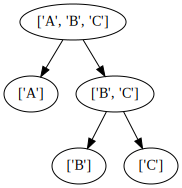

In [33]:
draw_mergesort_subproblems(['A', 'B', 'C'])

You should also implement `recursion.merge_sort_bottom_up_unstable_observed` and `recursion.merge_sort_bottom_up_observed`.

Unlike `merge_sort_observed`, they won't have a recursive helper function, since they do not involve recursion. They might not have helper functions at all. So requirements #1 and #2 listed above do not apply. **But #3 and #4 do still apply.**

The bottom-up implementations don't have explicit split operations. They start with the base case of singleton lists and merge from there. Nonetheless, write their `*_observed` implementations so they report each list with elements **without merge operations changing their order**, as if splitting *had* been done. This facilitates comparison to the top-down version. (Writing those implementations will also reveal something interesting about mergesort.)

**Hint:** If `merge_sort_bottom_up_unstable_observed` and `merge_sort_bottom_up_observed` were only required to make those calls to the observers, and were not also required to return a sorted result, then their code *might* be simpler.

Try out `merge_sort_bottom_up_unstable_observed` and `merge_sort_bottom_up_observed` with the same inputs as `merge_sort_observed`.

### `draw_mergesort_subproblems` with `merge_sort_bottom_up_unstable_observed`

`draw_mergesort_subproblems` with `merge_sort_bottom_up_unstable_observed` is a bit tricky because, for some inputs, there may be reasonable disagreement about exactly what sublists should be associated with nodes in the tree of subproblems. *In my opinion*, on `['A', 'B', 'C']`, the tree should be drawn as:

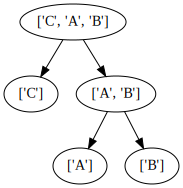

In [34]:
g = Digraph()
g.edge("['C', 'A', 'B']", "['C']")
g.edge("['C', 'A', 'B']", "['A', 'B']")
g.edge("['A', 'B']", "['A']")
g.edge("['A', 'B']", "['B']")
g

`['C', 'A', 'B']`?!

This is not a mistake... or, at least it is not a typo. We put `['A', 'B', 'C']` in, but I claim the root subproblem&mdash;what we often call the "full problem"&mdash;is really `['C', 'A', 'B']`? Am I right about this? What could justify such a claim?

<details>
<summary><strong><em>Spoiler!</em> Click to expand/collapse a hint about this.</strong></summary>
Suppose we say the root subproblem is the input itself. How does that work with input sizes that are larger (but that, like 3, are not powers of 2)?
</details>

If I am right, then the above drawing should look the same as the drawing below:

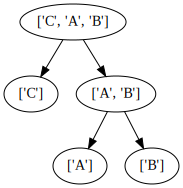

In [35]:
draw_mergesort_subproblems(['A', 'B', 'C'], sort=recursion.merge_sort_bottom_up_unstable_observed)

### `draw_mergesort_subproblems` with `merge_sort_bottom_up_observed`

Calling `draw_mergesort_subproblems` with `merge_sort_bottom_up_observed` on `['A', 'B', 'C']` should show the same drawing as:

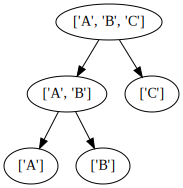

In [36]:
g = Digraph()
g.edge("['A', 'B', 'C']", "['A', 'B']")
g.edge("['A', 'B', 'C']", "['C']")
g.edge("['A', 'B']", "['A']")
g.edge("['A', 'B']", "['B']")
g

That is, the above drawing should look the same as the drawing below:

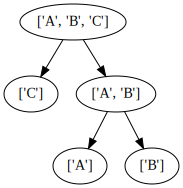

In [37]:
draw_mergesort_subproblems(['A', 'B', 'C'], sort=recursion.merge_sort_bottom_up_observed)

BUT IT DOESN'T. WHY DOESN'T IT??

**FIXME**: Figure out and fix this. Consider scrapping this whole extended exercise entirely if it looks like the time committment to fixing it, or the time it would take to actually *work* the exercises based on this writeup, can be seen to be excessive.

In [38]:
print(_)

digraph {
	2747399423168 [label="['A']"]
	2747399429824 [label="['B']"]
	2747399428096 [label="['C']"]
	2747323485056 [label="['A', 'B']"]
	2747323485056 -> 2747399423168
	2747323485056 -> 2747399429824
	2747399436288 [label="['A', 'B', 'C']"]
	2747399436288 -> 2747323485056
	2747399436288 -> 2747399428096
}



As shown above, the problem is that $C$ is added before $AB$.

But I am not sure there is any reasonable way to fix that when taking this approach. Building the tree and preorder traversing it to populate the graph would work. Listing the edges and topologically sorting them would work (and be overkill, except that Python has a standard library facility that might actually make that more compact). But the point of this exercise is to observe the behavior of the functions&mdash;or sham behavior that has directly corresponding logic&mdash;and build the trees by populating the graphs in the order nodes and edges are observed. I thought that was feasible, and that exercises could be made to carefully guide the reader to be able to do it, so the reader could focus on concepts and programming techniques rather than minutae about drawing. **I no longer believe that is most likely feasible.**

There is a slight chance this whole section of this notebook&mdash;*Mergesort - Drawing subproblem trees*&mdash;can somehow be fixed. Otherwise, I hope some of it can be salvaged in some way.

### Runs of all 3 observed implementations with various inputs:

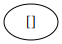

In [39]:
draw_mergesort_subproblems([])

In [40]:
draw_mergesort_subproblems([], sort=recursion.merge_sort_bottom_up_unstable_observed)

In [41]:
draw_mergesort_subproblems([], sort=recursion.merge_sort_bottom_up_observed)

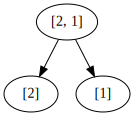

In [42]:
draw_mergesort_subproblems([2, 1])

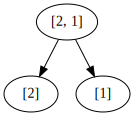

In [43]:
draw_mergesort_subproblems([2, 1], sort=recursion.merge_sort_bottom_up_unstable_observed)

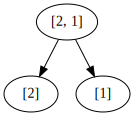

In [44]:
draw_mergesort_subproblems([2, 1], sort=recursion.merge_sort_bottom_up_observed)

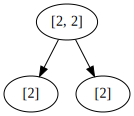

In [45]:
draw_mergesort_subproblems([2, 2])

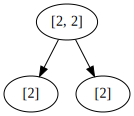

In [46]:
draw_mergesort_subproblems([2, 2], sort=recursion.merge_sort_bottom_up_unstable_observed)

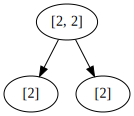

In [47]:
draw_mergesort_subproblems([2, 2], sort=recursion.merge_sort_bottom_up_observed)

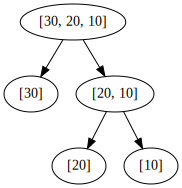

In [48]:
draw_mergesort_subproblems([30, 20, 10])

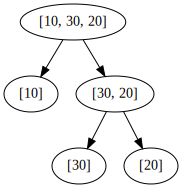

In [49]:
draw_mergesort_subproblems([30, 20, 10], sort=recursion.merge_sort_bottom_up_unstable_observed)

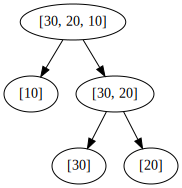

In [50]:
draw_mergesort_subproblems([30, 20, 10], sort=recursion.merge_sort_bottom_up_observed)

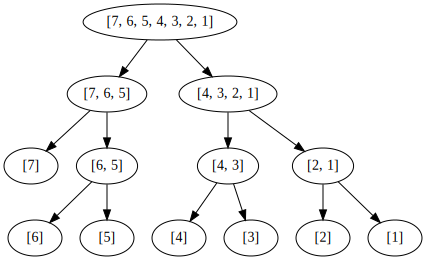

In [51]:
draw_mergesort_subproblems([7, 6, 5, 4, 3, 2, 1])

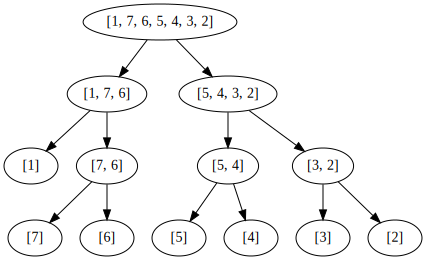

In [52]:
draw_mergesort_subproblems([7, 6, 5, 4, 3, 2, 1], sort=recursion.merge_sort_bottom_up_unstable_observed)

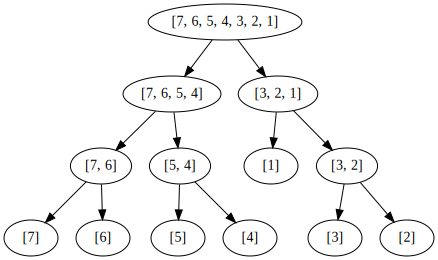

In [53]:
draw_mergesort_subproblems([7, 6, 5, 4, 3, 2, 1], sort=recursion.merge_sort_bottom_up_observed)

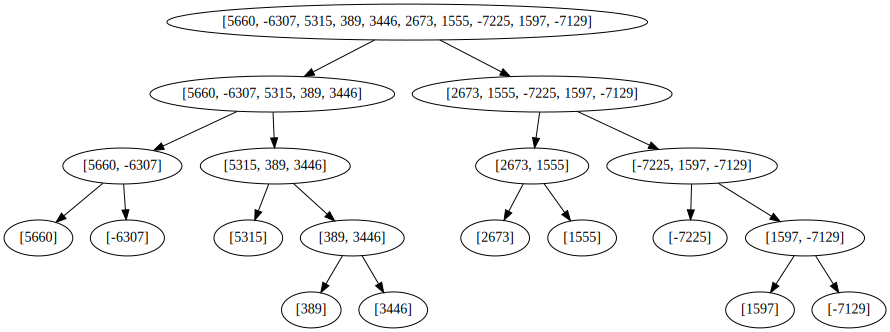

In [54]:
draw_mergesort_subproblems([5660, -6307, 5315, 389, 3446, 2673, 1555, -7225, 1597, -7129])

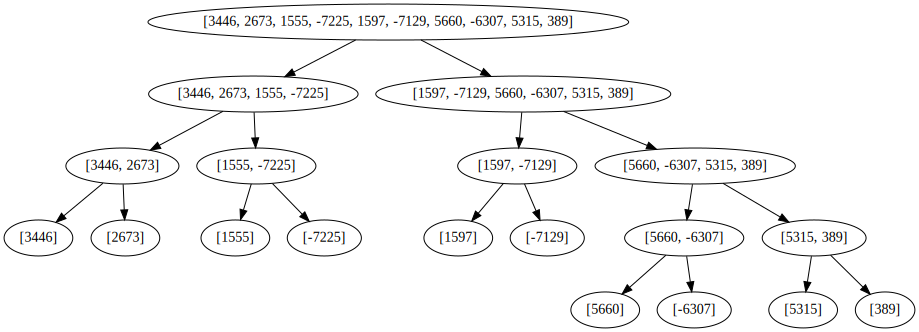

In [55]:
draw_mergesort_subproblems([5660, -6307, 5315, 389, 3446, 2673, 1555, -7225, 1597, -7129], sort=recursion.merge_sort_bottom_up_unstable_observed)

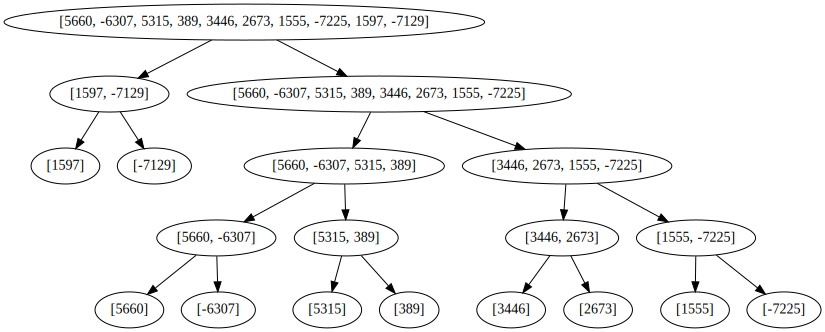

In [56]:
draw_mergesort_subproblems([5660, -6307, 5315, 389, 3446, 2673, 1555, -7225, 1597, -7129], sort=recursion.merge_sort_bottom_up_observed)

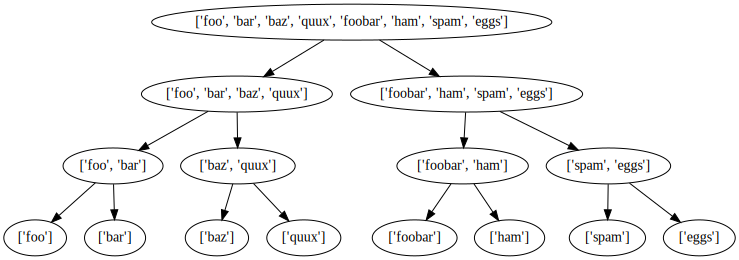

In [57]:
draw_mergesort_subproblems(['foo', 'bar', 'baz', 'quux', 'foobar', 'ham', 'spam', 'eggs'])

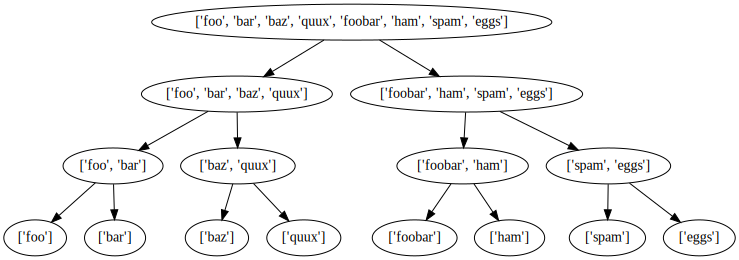

In [58]:
draw_mergesort_subproblems(['foo', 'bar', 'baz', 'quux', 'foobar', 'ham', 'spam', 'eggs'], sort=recursion.merge_sort_bottom_up_unstable_observed)

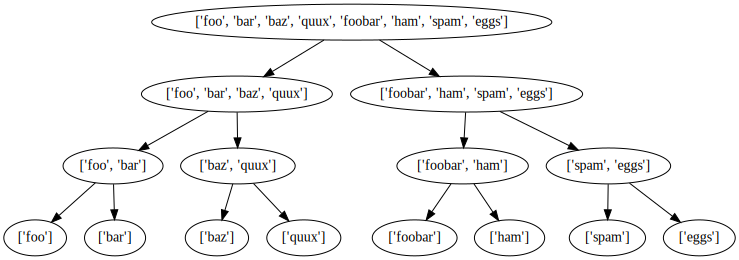

In [59]:
draw_mergesort_subproblems(['foo', 'bar', 'baz', 'quux', 'foobar', 'ham', 'spam', 'eggs'], sort=recursion.merge_sort_bottom_up_observed)